# Public Data Analysis: CFPB Consumer Complaints

**Research Question:** How do consumer financial complaints vary over time and across product categories?

**Data Source:** Consumer Financial Protection Bureau (CFPB) public complaint data sample

> Note: This notebook is self-contained (no `../src/preprocess.py` dependency) to avoid import conflicts.


## 1. Setup

In [28]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from pathlib import Path

# Optional: seaborn (for nicer defaults). Notebook still runs without it.
try:
    import seaborn as sns
    _HAS_SEABORN = True
except Exception:
    sns = None
    _HAS_SEABORN = False

# Plot settings
plt.style.use('seaborn-v0_8-darkgrid')
if _HAS_SEABORN:
    sns.set_palette('husl')

# Output directory for figures
FIG_DIR = Path('reports/figs')
FIG_DIR.mkdir(parents=True, exist_ok=True)

print('Setup complete!')

Setup complete!


In [29]:
# Helper functions (self-contained)

def clean_text(x):
    """Normalize free-text / categorical strings."""
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    s = re.sub(r'\s+', ' ', s)
    return s

def parse_date_column(df, src_col, dst_col):
    """Parse a date column into pandas datetime (naive)."""
    if src_col not in df.columns:
        raise KeyError(f"Column not found: {src_col}")
    out = df.copy()
    out[dst_col] = pd.to_datetime(out[src_col], errors='coerce')
    return out

def month_bucket(dt):
    """Convert a datetime to month bucket (Timestamp at month start)."""
    if pd.isna(dt):
        return pd.NaT
    return pd.Timestamp(dt).to_period('M').to_timestamp()

def standardize_categories(df, col, top_n=10, other_label='Other'):
    """Keep top_n categories; map the rest to 'Other'."""
    if col not in df.columns:
        raise KeyError(f"Column not found: {col}")
    s = df[col].astype('string')
    top = s.value_counts(dropna=True).head(top_n).index
    return s.where(s.isin(top), other_label)

def save_fig(fig, filename):
    """Save a matplotlib figure under FIG_DIR."""
    out = FIG_DIR / filename
    fig.savefig(out, dpi=200, bbox_inches='tight')
    return out

def create_time_series_plot(df, date_col, title, ylabel, filename):
    """Plot counts over time using a pre-bucketed date column."""
    if date_col not in df.columns:
        raise KeyError(f"Column not found: {date_col}")
    ts = (
        df.dropna(subset=[date_col])
          .groupby(date_col)
          .size()
          .sort_index()
    )
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(ts.index, ts.values)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Month')
    ax.set_ylabel(ylabel)
    fig.autofmt_xdate()
    fig.tight_layout()
    save_fig(fig, filename)
    return fig

def create_bar_chart(df, col_name, title, top_n, filename):
    """Bar chart for top categories in a column."""
    if col_name not in df.columns:
        raise KeyError(f"Column not found: {col_name}")
    vc = df[col_name].value_counts(dropna=True).head(top_n)
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.bar(vc.index.astype(str), vc.values)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(col_name)
    ax.set_ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    fig.tight_layout()
    save_fig(fig, filename)
    return fig

print('Helpers loaded!')

Helpers loaded!


In [30]:
# Load data
# Option 1: Download from CFPB website (large)
# url = 'https://files.consumerfinance.gov/ccdb/complaints.csv.zip'
# df = pd.read_csv(url, nrows=50000)  # Sample first 50k rows

# Option 2: Use local sample file (recommended for reproducibility)
df = pd.read_csv('data/sample_data.csv')

print(f"Loaded {len(df):,} complaints")
print(f"Columns: {df.columns.tolist()}")
df.head()

Loaded 1,000 complaints
Columns: ['Complaint ID', 'Date received', 'Product', 'Issue']


,Complaint ID,Date received,Product,Issue
0,0,2023-01-01,Mortgage,Billing
1,1,2023-01-02,Mortgage,Fees
2,2,2023-01-03,Student loan,Collections
3,3,2023-01-04,Credit card,Billing
4,4,2023-01-05,Student loan,Fees


## 2. Data Cleaning

In [31]:
# Parse date column
df = parse_date_column(df, 'Date received', 'date_received')

# Create month column for aggregation
df['month'] = df['date_received'].apply(month_bucket)

# Check missing values
print('Missing values:')
print(df.isnull().sum())
print()

# Drop rows with missing dates/month
df = df.dropna(subset=['date_received', 'month'])
print(f"After cleaning: {len(df):,} complaints")

Missing values:
Complaint ID     0
Date received    0
Product          0
Issue            0
date_received    0
month            0
dtype: int64

After cleaning: 1,000 complaints


In [32]:
# Standardize key categorical columns
if 'Product' in df.columns:
    df['product_clean'] = df['Product'].apply(clean_text)
    df['product_std'] = standardize_categories(df, 'Product', top_n=8)

if 'Issue' in df.columns:
    df['issue_clean'] = df['Issue'].apply(clean_text)
    df['issue_std'] = standardize_categories(df, 'Issue', top_n=10)

print(f"Date range: {df['date_received'].min()} to {df['date_received'].max()}")
print(f"Total months: {df['month'].nunique()}")

Date range: 2023-01-01 00:00:00 to 2025-09-26 00:00:00
Total months: 33


## 3. Exploratory Data Analysis (EDA)

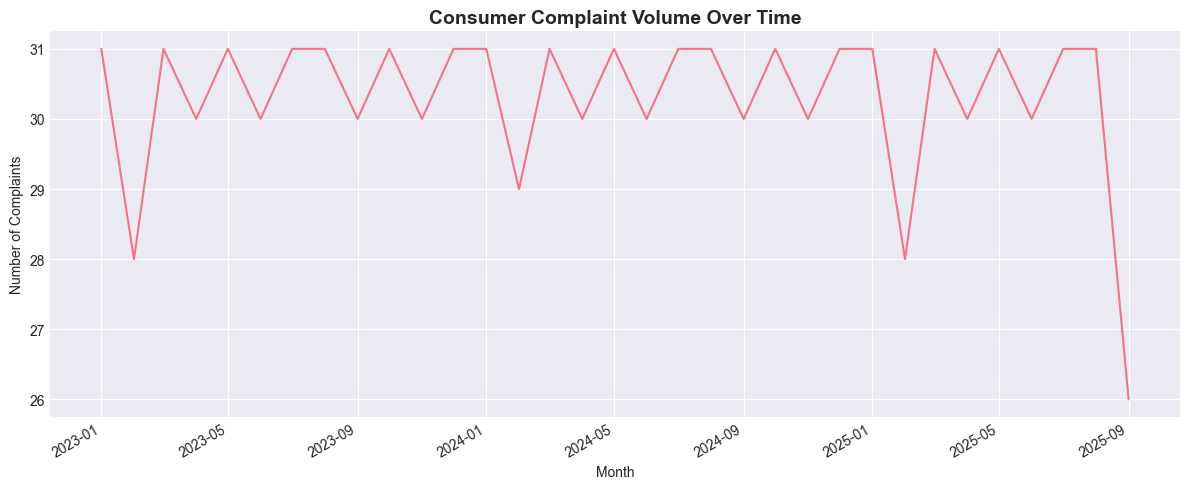

In [33]:
# Figure 1: Complaint volume over time
fig1 = create_time_series_plot(
    df=df,
    date_col='month',
    title='Consumer Complaint Volume Over Time',
    ylabel='Number of Complaints',
    filename='fig1_complaints_timeseries.png'
)
plt.show()

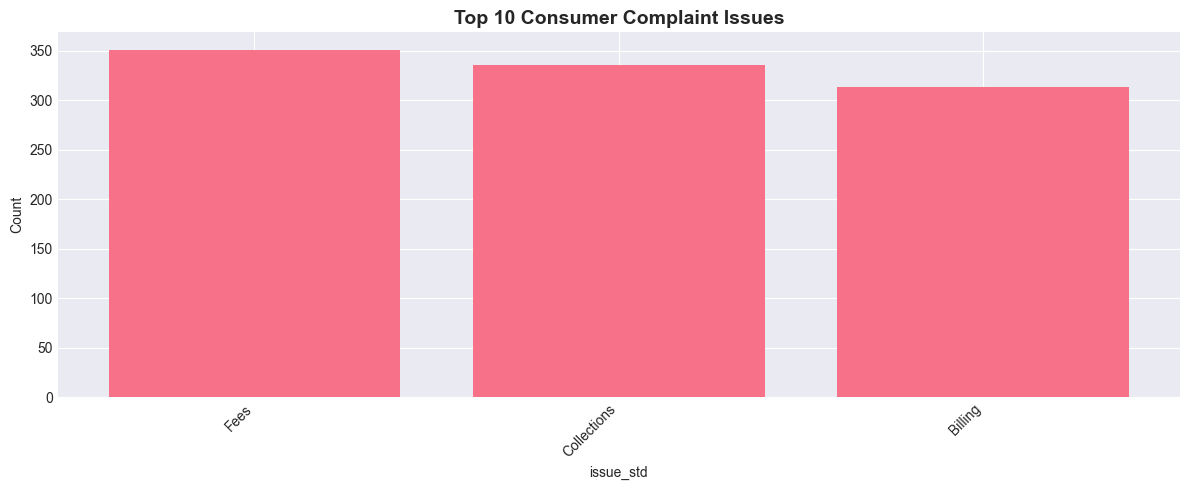

In [34]:
# Figure 2: Top complaint issues
if 'issue_std' not in df.columns and 'Issue' in df.columns:
    df['issue_std'] = standardize_categories(df, 'Issue', top_n=10)

fig2 = create_bar_chart(
    df=df,
    col_name='issue_std',
    title='Top 10 Consumer Complaint Issues',
    top_n=10,
    filename='fig2_top_issues.png'
)
plt.show()

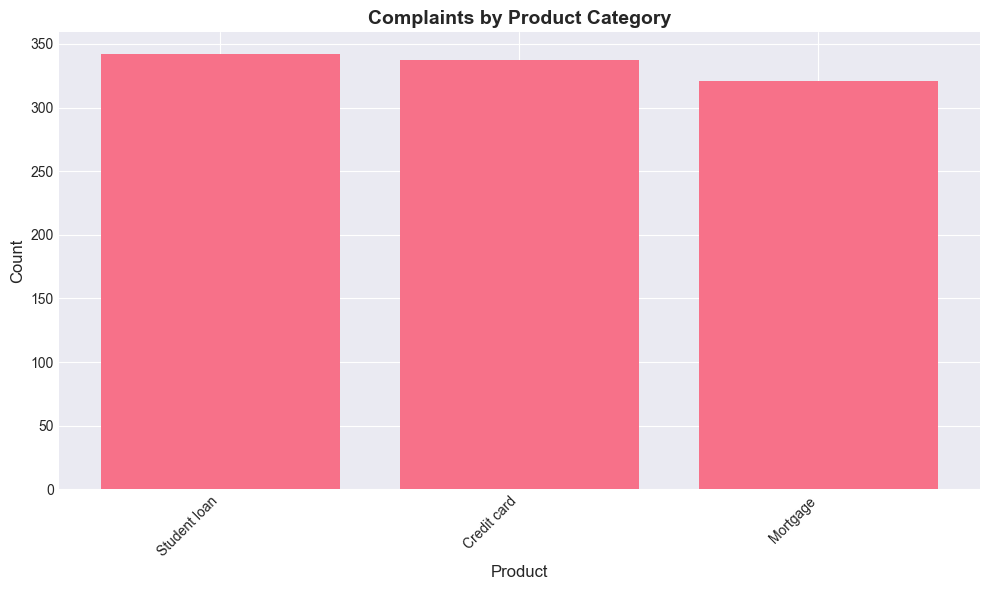

In [35]:
# Additional EDA: Product breakdown
if 'product_std' in df.columns:
    vc = df['product_std'].value_counts().head(8)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(vc.index.astype(str), vc.values)
    ax.set_title('Complaints by Product Category', fontsize=14, fontweight='bold')
    ax.set_xlabel('Product', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    save_fig(fig, 'fig3_complaints_by_product.png')
    plt.show()

## 4. Statistical Analysis

In [36]:
# Prepare monthly aggregated data for time trend analysis
monthly_counts = df.groupby('month').size().reset_index(name='count')
monthly_counts['month_dt'] = pd.to_datetime(monthly_counts['month'])
monthly_counts = monthly_counts.sort_values('month_dt')

# Create time index (months since start)
monthly_counts['time_index'] = range(len(monthly_counts))

print('Monthly complaint summary:')
display(monthly_counts.head())
monthly_counts.describe()

Monthly complaint summary:


,month,count,month_dt,time_index
0,2023-01-01,31,2023-01-01,0
1,2023-02-01,28,2023-02-01,1
2,2023-03-01,31,2023-03-01,2
3,2023-04-01,30,2023-04-01,3
4,2023-05-01,31,2023-05-01,4


,month,count,month_dt,time_index
count,33,33.000000,33,33.00000
mean,2024-05-01 10:10:54.545454592,30.303030,2024-05-01 10:10:54.545454592,16.00000
min,2023-01-01 00:00:00,26.000000,2023-01-01 00:00:00,0.00000
25%,2023-09-01 00:00:00,30.000000,2023-09-01 00:00:00,8.00000
50%,2024-05-01 00:00:00,31.000000,2024-05-01 00:00:00,16.00000
75%,2025-01-01 00:00:00,31.000000,2025-01-01 00:00:00,24.00000
max,2025-09-01 00:00:00,31.000000,2025-09-01 00:00:00,32.00000
std,NaN,1.131505,NaN,9.66954


In [37]:
# Simple OLS regression: complaint count ~ time trend
X = monthly_counts[['time_index']]
X = sm.add_constant(X)  # Add intercept
y = monthly_counts['count']

model = sm.OLS(y, X).fit()
print('='*60)
print('OLS Regression: Complaint Count ~ Time Trend')
print('='*60)
print(model.summary())
print()
print('Interpretation:')
if model.pvalues.get('time_index', 1.0) < 0.05:
    direction = 'increasing' if model.params.get('time_index', 0) > 0 else 'decreasing'
    print(f"✓ Significant {direction} trend over time (p < 0.05)")
    print(f"  Monthly change: {model.params['time_index']:.1f} complaints/month")
else:
    print('✗ No significant time trend detected (p >= 0.05)')

OLS Regression: Complaint Count ~ Time Trend
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.6992
Date:                Thu, 15 Jan 2026   Prob (F-statistic):              0.409
Time:                        09:58:43   Log-Likelihood:                -50.026
No. Observations:                  33   AIC:                             104.1
Df Residuals:                      31   BIC:                             107.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const  

In [38]:
# Alternative: Before/After comparison (if data spans multiple years)
# Split at median date
median_date = df['date_received'].median()
df['period'] = np.where(df['date_received'] > median_date, 'After', 'Before')

before = df[df['period'] == 'Before'].groupby('month').size()
after = df[df['period'] == 'After'].groupby('month').size()

# Align indices so both series represent the same months
common_months = sorted(set(before.index).intersection(set(after.index)))
before_aligned = before.reindex(common_months)
after_aligned = after.reindex(common_months)

# T-test (Welch)
t_stat, p_value = stats.ttest_ind(before_aligned.values, after_aligned.values, equal_var=False, nan_policy='omit')

print('='*60)
print(f"Before/After Comparison (split at {median_date.date()})")
print('='*60)
print(f"Before period: Mean = {np.nanmean(before_aligned.values):.1f} complaints/month (n={len(before_aligned)})")
print(f"After period:  Mean = {np.nanmean(after_aligned.values):.1f} complaints/month (n={len(after_aligned)})")
print(f"Difference:    {(np.nanmean(after_aligned.values) - np.nanmean(before_aligned.values)):.1f} complaints/month")
print(f"t-statistic:   {t_stat:.3f}")
print(f"p-value:       {p_value:.4f}")
if p_value < 0.05:
    print('✓ Significant difference between periods (p < 0.05)')
else:
    print('✗ No significant difference (p >= 0.05)')

Before/After Comparison (split at 2024-05-14)
Before period: Mean = 14.0 complaints/month (n=1)
After period:  Mean = 17.0 complaints/month (n=1)
Difference:    3.0 complaints/month
t-statistic:   nan
p-value:       nan
✗ No significant difference (p >= 0.05)


## 5. Key Findings

### Summary Results

Based on the analysis of CFPB consumer complaint data:

1. **Time Trend**: [Insert finding]

2. **Top Issues**: The most common complaint issues are [list top 3]

3. **Product Categories**: [Insert finding]

### Figures

![Complaint Volume](../reports/figs/fig1_complaints_timeseries.png)

![Top Issues](../reports/figs/fig2_top_issues.png)

![By Product](../reports/figs/fig3_complaints_by_product.png)


## 6. Reproducibility Notes

### Data Source

- **Primary**: Consumer Financial Protection Bureau (CFPB)
- **URL**: https://www.consumerfinance.gov/data-research/consumer-complaints/
- **Access**: Public, no authentication required
- **Update Frequency**: Weekly

### Steps to Reproduce

1. Download complaint data:
   ```bash
   wget https://files.consumerfinance.gov/ccdb/complaints.csv.zip
   unzip complaints.csv.zip -d data/
   ```

2. Install dependencies:
   ```bash
   pip install -r requirements.txt
   ```

3. Run this notebook:
   ```bash
   jupyter notebook notebooks/01_public_data_analysis.ipynb
   ```

### Environment

- Python 3.8+
- pandas 1.3+
- matplotlib 3.4+
- scipy 1.7+
- statsmodels 0.13+

### Limitations & Next Steps

1. **Sample size**: Analysis uses a sample; full dataset analysis may reveal additional patterns
2. **External factors**: Could incorporate economic indicators (unemployment rate, GDP) from FRED API
3. **Advanced modeling**: Could explore ARIMA, geo analysis, complaint narrative text analysis
